# Examining the difference between mean minimum and maximum daily temperatures at UBC and SFU

## 1. Introduction

<span style="color:red">TODO</span>

## 2. Methods and Results

This section consists of:
- 2.1. R Preamble
- 2.2. Preliminary Results
- 2.3. Data Analysis

### 2.1. R Preamble

In [19]:
# Run this first.
library(tidyverse)
library(tidymodels)

set.seed(5)
options(repr.plot.width = 6, repr.plot.height = 4)

SRC <-
    c("https://raw.githubusercontent.com/arthu-rguo/stat-201-proj/main/ubc.csv",
      "https://raw.githubusercontent.com/arthu-rguo/stat-201-proj/main/sfu.csv")

### 2.2. Preliminary Results

#### 2.2.1. Loading and wrangling the dataset

Note that the raw UBC and SFU datasets span different date ranges. However, our analysis will focus mainly on the minimum and maximum daily temperatures, which might vary depending on the date. To prevent this from potentially skewing our results, we filter our wrangled dataset such that it spans the intersection of the UBC and SFU date ranges (from January 1 to June 30, 1995).

In [2]:
# Load and label the raw datasets for UBC and SFU, respectively.
ubc_raw <- read_csv(SRC[1], show_col_types = FALSE) |>
    mutate(location = as.factor("UBC"))

sfu_raw <- read_csv(SRC[2], show_col_types = FALSE) |>
    mutate(location = as.factor("SFU"))

# Join the datasets, select the relevant variables, and tidy the data.
ubc_sfu_raw <- bind_rows(ubc_raw, sfu_raw) |>
    rename(date_time = "Date/Time", 
           min_temp_c = "Min Temp (°C)", max_temp_c = "Max Temp (°C)") |>
    select(location, date_time, min_temp_c, max_temp_c) |>
    filter(!is.na(min_temp_c), !is.na(max_temp_c))

# Find the intersection of the date ranges and filter the dataset.
date_range <- ubc_sfu_raw |>
    group_by(location) |>
    summarize(min = min(date_time), max = max(date_time)) |>
    ungroup() |>
    summarize(min = max(min), max = min(max))

ubc_sfu_data <- ubc_sfu_raw |>
    filter(between(date_time, date_range$min, date_range$max))

# Preview the dataset.
cat("Table 1. Preview of tidy data for UBC and SFU")
head(ubc_sfu_data)
tail(ubc_sfu_data)

Table 1. Preview of tidy data for UBC and SFU

location date_time  min_temp_c max_temp_c
1 UBC      1995-01-01 -3.5       4.0       
2 UBC      1995-01-02 -3.5       4.0       
3 UBC      1995-01-03 -4.5       4.5       
4 UBC      1995-01-04 -5.0       4.0       
5 UBC      1995-01-05 -4.0       3.0       
6 UBC      1995-01-06 -4.0       3.0

location date_time  min_temp_c max_temp_c
1 SFU      1995-06-25 12         24.0      
2 SFU      1995-06-26 12         22.0      
3 SFU      1995-06-27 16         25.0      
4 SFU      1995-06-28 19         29.0      
5 SFU      1995-06-29 20         29.5      
6 SFU      1995-06-30 21         30.0

#### 2.2.2. Summary statistics

We calculate the summary statistics of interest for both UBC and SFU. The sample sizes are slightly different, but this should not a problem as both asymptotic and bootstrapping methods can account for this.

Overall, we can see that the mean minimum daily temperature at UBC in 1995 was 6.28°C, which is higher than the mean minimum daily temperature of 5.73°C at SFU, but both mean maximum daily temperatures are very similar at around 13.11°C.

In [3]:
# Calculate means, standard deviations, and counts for both locations.
ubc_sfu_summary <- ubc_sfu_data |>
    group_by(location) |>
    summarize(mean_min = mean(min_temp_c), sd_min = sd(min_temp_c),
              mean_max = mean(max_temp_c), sd_max = sd(max_temp_c),
              n = n())

# Storing these values to be used later.
ubc_mean_min <- as.numeric(ubc_sfu_summary[1,2])
sfu_mean_min <- as.numeric(ubc_sfu_summary[2,2])

ubc_sd_min <- as.numeric(ubc_sfu_summary[1,3])
sfu_sd_min <- as.numeric(ubc_sfu_summary[2,3])

ubc_mean_max <- as.numeric(ubc_sfu_summary[1,4])
sfu_mean_max <- as.numeric(ubc_sfu_summary[2,4])

ubc_sd_max <- as.numeric(ubc_sfu_summary[1,5])
sfu_sd_max <- as.numeric(ubc_sfu_summary[2,5])

ubc_n <- as.numeric(ubc_sfu_summary[1,6])
sfu_n <- as.numeric(ubc_sfu_summary[2,6])

cat("Table 2. Summary statistics for UBC and SFU")
ubc_sfu_summary

Table 2. Summary statistics for UBC and SFU

location mean_min sd_min   mean_max sd_max   n  
1 UBC      6.279006 4.821630 13.10773 5.523258 181
2 SFU      5.770950 4.812559 13.11732 6.357132 179

#### 2.2.3. Preliminary visualization

Plotting and comparing the sample distributions for both locations suggests that minimum and maximum daily temperatures might not be normally distributed—in particular, the distributions for UBC seem somewhat bimodal. Nonetheless, our sample sizes of 179 and 181 are still large enough for the Central Limit Theorem (CLT) to apply.

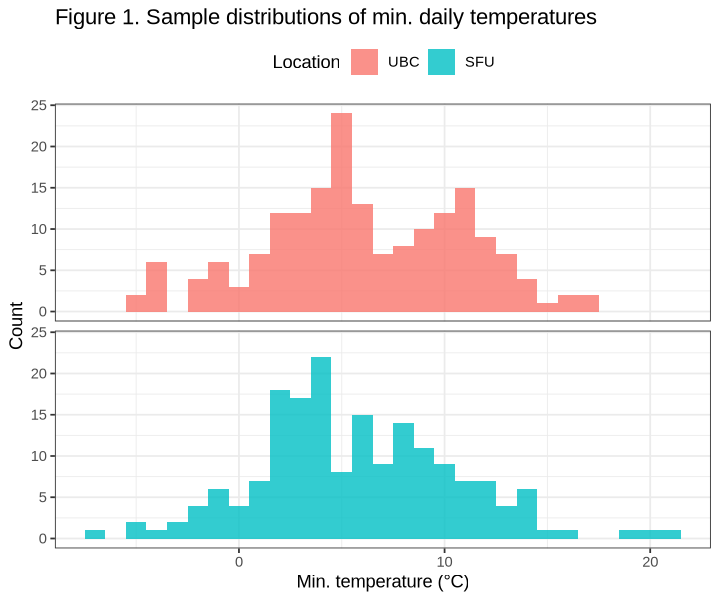

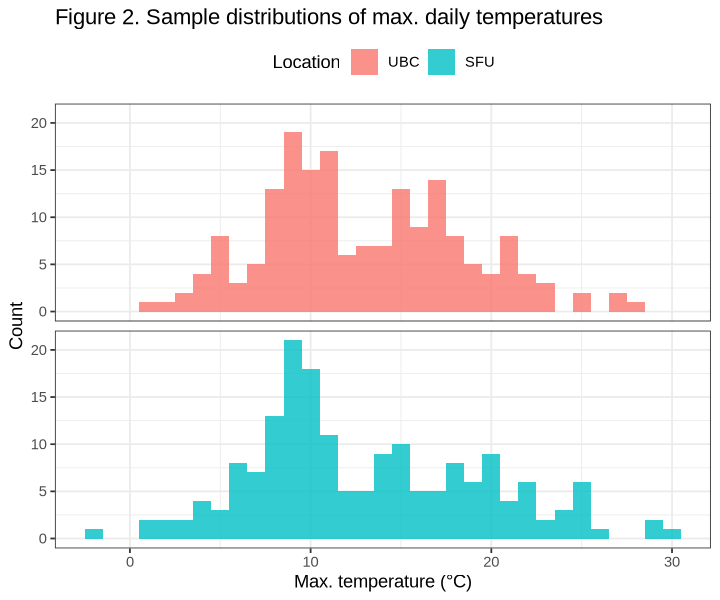

In [25]:
# Plot sample distributions for min. daily temperatures.
ubc_sfu_min_sample_dist <- ubc_sfu_data |>
    ggplot(aes(x = min_temp_c, fill = location)) +
        geom_histogram(binwidth = 1, alpha = 0.8) +
        labs(title = "Figure 1. Sample distributions of min. daily temperatures",
             x = "Min. temperature (°C)", y = "Count", fill = "Location") +
        facet_wrap(~location, ncol = 1) +
        theme_bw() +
        theme(legend.position = "top", 
              strip.background = element_blank(), strip.text = element_blank())

# Plot sample distributions for max. daily temperatures.
ubc_sfu_max_sample_dist <- ubc_sfu_data |>
    ggplot(aes(x = max_temp_c, fill = location)) +
        geom_histogram(binwidth = 1, alpha = 0.8) +
        labs(title = "Figure 2. Sample distributions of max. daily temperatures",
             x = "Max. temperature (°C)", y = "Count", fill = "Location") +
        facet_wrap(~location, ncol = 1) +
        theme_bw() +
        theme(legend.position = "top", 
              strip.background = element_blank(), strip.text = element_blank())

ubc_sfu_min_sample_dist
ubc_sfu_max_sample_dist

To get a better idea of the centers and spreads of the sample distributions, we can also compare boxplots. We see that both sample distributions for minimum and maximum daily temperatures (especially SFU's maximum temperatures) are slightly right-skewed.

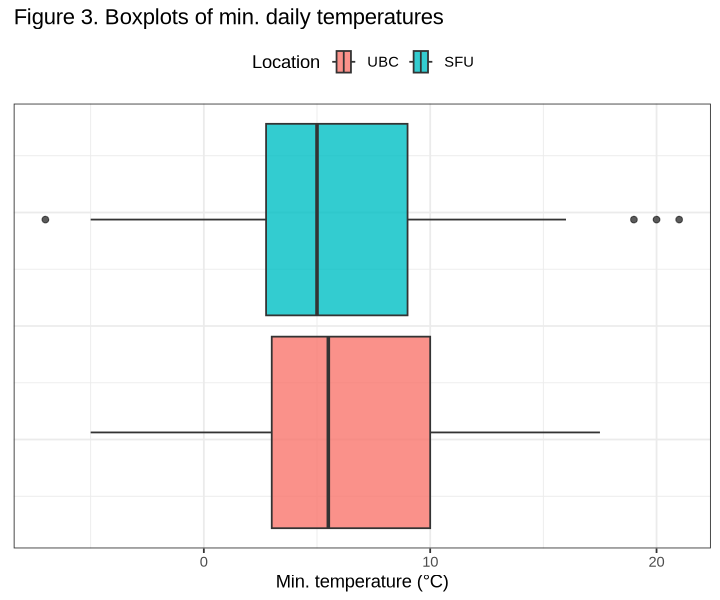

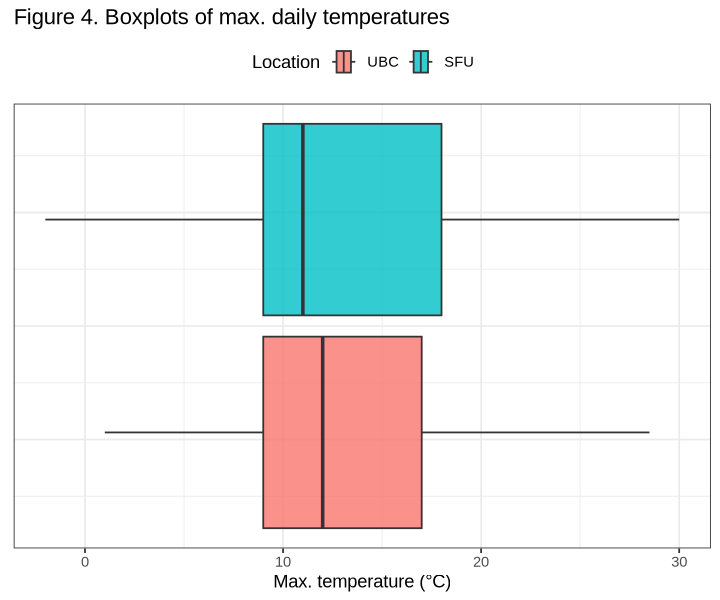

In [26]:
# Create boxplots for min. daily temperatures.
ubc_sfu_min_boxplot <- ubc_sfu_data |>
    ggplot(aes(x = min_temp_c, fill = location)) +
        geom_boxplot(alpha = 0.8) + 
        labs(title = "Figure 3. Boxplots of min. daily temperatures",
             x = "Min. temperature (°C)", fill = "Location") +
        theme_bw() +
        theme(legend.position = "top", 
              axis.text.y = element_blank(), axis.ticks.y = element_blank())

# Create boxplots for max. daily temperatures.
ubc_sfu_max_boxplot <- ubc_sfu_data |>
    ggplot(aes(x = max_temp_c, fill = location)) +
        geom_boxplot(alpha = 0.8) + 
        labs(title = "Figure 4. Boxplots of max. daily temperatures",
             x = "Max. temperature (°C)", fill = "Location") +
        theme_bw() +
        theme(legend.position = "top", 
              axis.text.y = element_blank(), axis.ticks.y = element_blank())

ubc_sfu_min_boxplot
ubc_sfu_max_boxplot

### 2.3 Data Analysis

#### 2.3.1. Plan

Our objective is to assess whether there is a statistically significant difference between the mean minimum and maximum daily temperatures at UBC and SFU. Although we have computed summary statistics for our sample, single point estimates do not provide sufficient evidence (Table 2). Hence, we will use the more robust method of hypothesis tests to draw conclusions about the population.

The first hypothesis test will assess whether there is a difference in the mean minimum daily temperatures at UBC and SFU at the 5% significance level. The second hypothesis test will do the same, but for the mean maximum daily temperatures instead. Let $\mu_1$ represent the mean minimum or maximum daily temperature at UBC and $\mu_2$ the same for SFU. Then, both hypothesis tests can be summarized as follows.

$$H_0 : \mu_1 = \mu_2, \quad H_A : \mu_1 \neq \mu_2, \quad \alpha = 0.05$$

Despite the slight skew found in our preliminary results, our sample is sufficiently large and consists of randomly and independently sampled data, which satisfies the assumptions of the CLT (Figures 3–6). Hence, each hypothesis test will be performed once using an asymptotic method, then again using a bootstrapping method. We will first perform a two-sample t-test in order to calculate a p-value for the hypothesis test. Additionally, we may report a 95% confidence interval for each population parameter. We will then perform a two-sample permutation test in order to obtain an alternative p-value and confidence intervals. 

The results of both methods will be compared and contrasted, though we expect that the two methods should produce similar results. To conclude, we will either reject or fail to reject our null hypotheses based on the calculated p-values from both methods, addressing our research objective.

#### 2.3.2 Two-sample t-tests

Recall that our sample sizes for UBC and SFU are 181 and 179, respectively. Hence, we will use the Central Limit Theorem to assume that the sampling distributions for both populations will be roughly normal. 

Unfortunately, we do not have access to the population standard deviations of the mean minimum and maximum daily temperatures at UBC and SFU. Though we can compute standard errors from our sample data, we cannot be certain that they will reasonably approximate the population standard deviations either. As a result, we opt to conduct two-sample t-tests rather than z-tests.

In [30]:
# Split the datasets.
ubc_data <- ubc_sfu_data |>
    filter(location == "UBC")

sfu_data <- ubc_sfu_data |>
    filter(location == "SFU")

# Conduct a two-sample t-test for the difference in mean min. daily temperatures.
min_t_test <- 
    t.test(x = ubc_data$min_temp_c, y = sfu_data$min_temp_c, 
           alternative = "two.sided", conf.level = 0.95) 
    tidy()

cat("Table 3. Two-sample t-test for difference in mean min. daily temperatures")
min_t_test

Table 3. Two-sample t-test for difference in min temps

p.value   conf.low   conf.high method                  alternative
1 0.3177157 -0.4905347 1.506646  Welch Two Sample t-test two.sided

Reading off of the output of `t.test`, we see that the p-value for our two-sample t-test is 0.3177157. This means that under the null hypothesis, there is about a 31.78% chance of obtaining a result as or more extreme. Therefore, at a significance level of 0.05, we fail to reject the null hypothesis that the mean minimum daily temperatures of UBC and SFU are the same.

In [54]:
# Get degrees of freedom from t.test
min_df <- as.numeric(min_t_test[6])

# Use equations for confidence intervals for two-sample difference of means
min_ci <- tibble(
    lower_ci = ubc_mean_min - sfu_mean_min + qt(0.025, df = min_df) * sqrt(ubc_sd_min^2/ubc_n + sfu_sd_min^2/sfu_n),
    upper_ci = ubc_mean_min - sfu_mean_min + qt(0.975, df = min_df) * sqrt(ubc_sd_min^2/ubc_n + sfu_sd_min^2/sfu_n))

cat("Table 4. 95% confidence interval for difference in mean min temp using t-distribution")
min_ci

Table 4. 95% confidence interval for difference in mean min temp using t-distribution

lower_ci   upper_ci
1 -0.4905347 1.506646

We get a 95% confidence interval of (-0.4905347, 1.506646) for the difference in mean minimum daily temperature of UBC and SFU. This means that we are 95% confident that the true difference in mean minimum daily temperature between UBC and SFU is between -0.4905347 and 1.506646. Also, since the interval contains 0, it makes sense that we failed to reject the null hypothesis because it means it is quite likely that there is no difference in mean max temps.

In [51]:
# Use R's t.test function to conduct two-sample t-test for max temp 
cat("Table 5. Two-sample t-test for difference in max temps")
max_t_test<- 
    tidy(t.test(x = pull(select(filter(ubc_sfu_data, location == "UBC"), max_temp_c)),
           y = pull(select(filter(ubc_sfu_data, location == "SFU"), max_temp_c)),
           alternative = "t",
           correct = FALSE,
           conf.level = 0.95))
max_t_test

Table 5. Two-sample t-test for difference in max temps

p.value   conf.low  conf.high method                  alternative
1 0.9878319 -1.244604 1.225436  Welch Two Sample t-test two.sided

Repeating for max temp, the p-value for our two-sample t-test is 0.9878319. This means that under the null hypothesis, there is about a 98.78% chance of obtaining a result as or more extreme. Therefore, at a significance level of 0.05, we fail to reject the null hypothesis that the mean maximum daily temperatures of UBC and SFU are the same.

In [73]:
# Get degrees of freedom from t.test
max_df <- as.numeric(max_t_test[6])

# Use equations for confidence intervals for two-sample difference of means
max_ci <- tibble(
    lower_ci = ubc_mean_max - sfu_mean_max + qt(0.025, df = max_df) * sqrt(ubc_sd_max^2/ubc_n + sfu_sd_max^2/sfu_n),
    upper_ci = ubc_mean_max - sfu_mean_max + qt(0.975, df = max_df) * sqrt(ubc_sd_max^2/ubc_n + sfu_sd_max^2/sfu_n))

cat("Table 6. 95% confidence interval for difference in mean max temp using t-distribution")
max_ci

Table 6. 95% confidence interval for difference in mean max temp using t-distribution

lower_ci  upper_ci
1 -1.244604 1.225436

We get a 95% confidence interval of (-1.244604, 1.225436) for the difference in mean maximum daily temperature of UBC and SFU. This means that we are 95% confident that the true difference in mean maximum daily temperature between UBC and SFU is between -1.244604 and 1.225436. Since the interval contains 0, it makes sense that we failed to reject the null hypothesis.

### 2.3.3 Two-sample permutation test
We will now use bootstrapping to conduct the same hypothesis tests and to obtain confidence intervals as above.

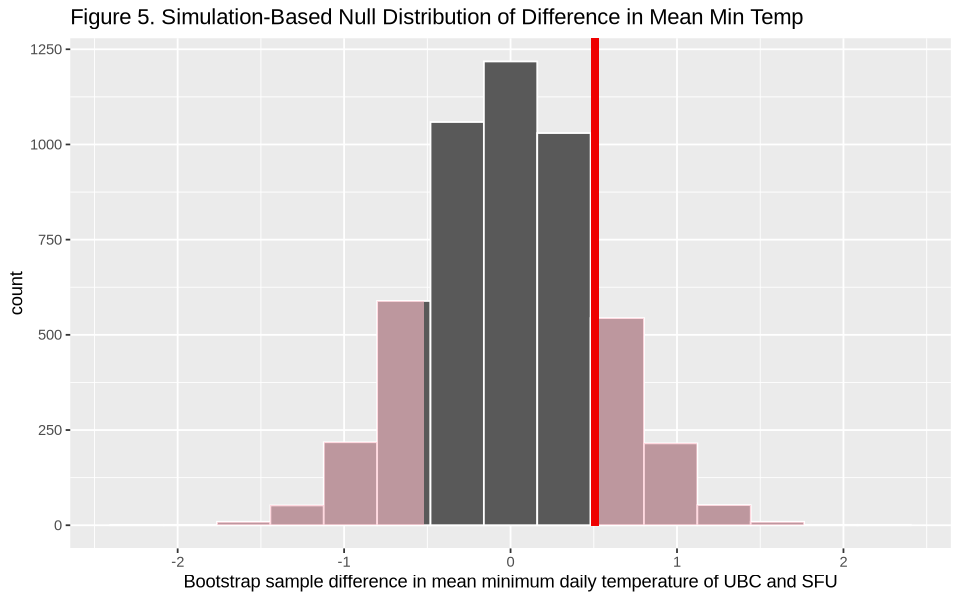

In [67]:
set.seed(2023)
# Obtain a simulation-based null distribution using 5000 permutations
null_min <- ubc_sfu_data %>% 
    specify(min_temp_c ~ location) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 5000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("UBC", "SFU"))

options(repr.plot.width = 8, repr.plot.height = 5)
# Visualize sampling distribution assuming null hypothesis is true
null_dist_min <- null_min %>%
    visualize() +
    shade_p_value(obs_stat = ubc_mean_min - sfu_mean_min, direction = "two-sided") +
    xlab("Bootstrap sample difference in mean minimum daily temperature of UBC and SFU") +
    ggtitle("Figure 5. Simulation-Based Null Distribution of Difference in Mean Min Temp")

null_dist_min

Based on the null distribution, it appears that the observed difference in mean minimum daily temperatures is quite likely when the null hypothesis is true. To confirm, we can get the p-value:

In [68]:
# Get the p-value based on the observed difference in mean min temp
diff_min_p <- null_min %>%
    get_p_value(obs_stat = ubc_mean_min - sfu_mean_min, direction = "two-sided") %>%
    as.numeric()
diff_min_p

[1] 0.3096

We get a p-value of 0.3096, which is quite close to the p-value we got from the two-sample t-test (0.3177157). Because of this, we have the same conclusion at a significance level of 0.05: we fail to reject the null hypothesis that the mean minimum daily temperatures of UBC and SFU are the same. Next, we will find a 95% confidence interval for the difference in mean min temp using bootstrapping.

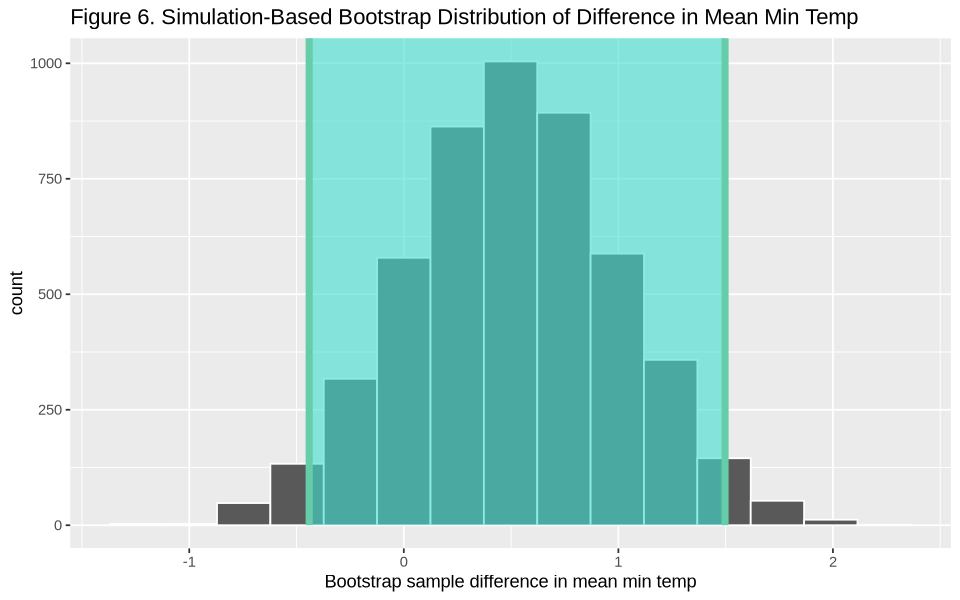

In [69]:
set.seed(2023)
# Find bootstrap distribution
bootstrap_min <- ubc_sfu_data %>% 
    specify(min_temp_c ~ location) %>%
    generate(reps = 5000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("UBC", "SFU")) 

# Obtain a 95% confidence interval
bootstrap_min_ci <- bootstrap_min %>%
    summarise(lower_ci = quantile(stat, 0.025), upper_ci = quantile(stat, 0.975))

# Visualize the confidence interval
bootstrap_min_ci_plot <- bootstrap_min %>%
    visualize() +
    shade_ci(bootstrap_min_ci) +
    ggtitle("Figure 6. Simulation-Based Bootstrap Distribution of Difference in Mean Min Temp") +
    xlab("Bootstrap sample difference in mean min temp")

bootstrap_min_ci_plot

In [74]:
cat("Table 7. 95% confidence interval for difference in mean min temp using bootstrapping")
bootstrap_min_ci

Table 7. 95% confidence interval for difference in mean min temp using bootstrapping

lower_ci   upper_ci
1 -0.4411245 1.497218

Again, we get a result similar to the one obtained using asymptotics. Our 95% confidence interval is (-0.4411245, 1.497218), meaning we are 95% confident that the true difference in mean minimum temperatures between UBC and SFU is between -0.4411245 and 1.497218. Since the interval contains 0, it makes sense that we failed to reject the null hypothesis.

We repeat the above steps for mean max temp:

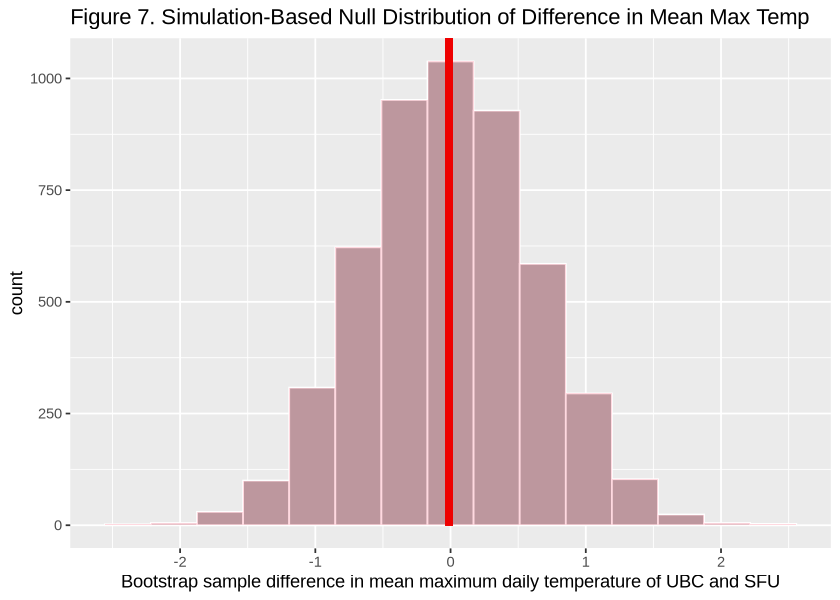

In [64]:
set.seed(2023)
# Obtain a simulation-based null distribution using 5000 permutations
null_max <- ubc_sfu_data %>% 
    specify(max_temp_c ~ location) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 5000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("UBC", "SFU"))

options(repr.plot.width = 7, repr.plot.height = 5)
# Visualize sampling distribution assuming null hypothesis is true
null_dist_max <- null_max %>%
    visualize() +
    shade_p_value(obs_stat = ubc_mean_max - sfu_mean_max, direction = "two-sided") +
    xlab("Bootstrap sample difference in mean maximum daily temperature of UBC and SFU") +
    ggtitle("Figure 7. Simulation-Based Null Distribution of Difference in Mean Max Temp")

null_dist_max

Based on the null distribution, we can tell that we will likely fail to reject the null hypothesis since our observed result seems to be very likely assuming the null hypothesis is true, but we will find the p-value anyways:

In [60]:
# Get the p-value based on the observed difference in mean max temp
diff_max_p <- null_max %>%
    get_p_value(obs_stat = ubc_mean_max - sfu_mean_max, direction = "two-sided") %>%
    as.numeric()
diff_max_p

[1] 0.9964

We get a p-value of 0.9964, which is again quite similar to the one obtained with asymptotics (0.9878319), leading to the same conclusion: at a significance level of 0.05, we fail to reject the null hypothesis that the mean maximum daily temperatures of UBC and SFU are the same. We will find a 95% confidence interval for the difference in mean max temp using bootstrapping:

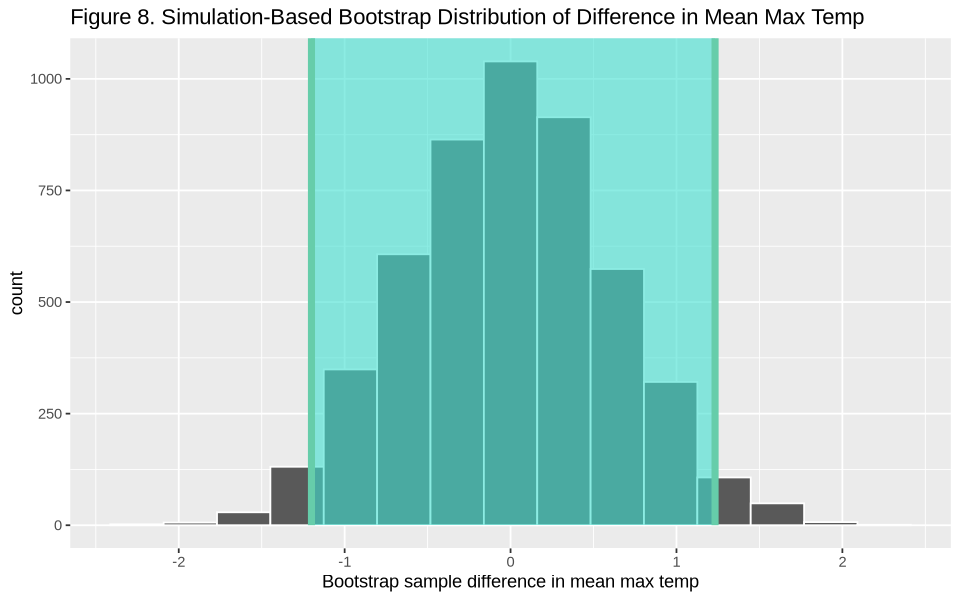

In [70]:
set.seed(2023)
# Find bootstrap distribution
bootstrap_max <- ubc_sfu_data %>% 
    specify(max_temp_c ~ location) %>%
    generate(reps = 5000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("UBC", "SFU")) 

# Obtain a 95% confidence interval
bootstrap_max_ci <- bootstrap_max %>%
    summarise(lower_ci = quantile(stat, 0.025), upper_ci = quantile(stat, 0.975))

# Visualize the confidence interval
bootstrap_max_ci_plot <- bootstrap_max %>%
    visualize() +
    shade_ci(bootstrap_max_ci) +
    ggtitle("Figure 8. Simulation-Based Bootstrap Distribution of Difference in Mean Max Temp") +
    xlab("Bootstrap sample difference in mean max temp")

bootstrap_max_ci_plot

In [75]:
cat("Table 8. 95% confidence interval for difference in mean max temp using boostrapping")
bootstrap_max_ci

Table 8. 95% confidence interval for difference in mean max temp using boostrapping

lower_ci  upper_ci
1 -1.200007 1.232599

Again, our result is quite similar to the one obtained using asymptotics. Our 95% confidence interval is (-1.200007, 1.232599), meaning we are 95% confident that the true difference in mean maximum temperatures between UBC and SFU is between -1.200007 and 1.232599. Since this interval contains 0, it makes sense that we failed to reject the null hypothesis above.

---
- [x] state null hypotheses alternative hypotheses
  - [x] state significance level
- [x] two sample t test diff in means
  - [x] determine p-values
  - [x] two 95% confidence intervals
- [ ] two sample permutation test diff in means
  - [ ] determine p-values
  - [ ] two 95% confidence intervals
---

## 3. Discussion

<span style="color:red">TODO</span>

## 4. References

1. Beecher, M. E., Eggett, D., Erekson, D., Rees, L. B., Bingham, J., Klundt, J., Bailey, R. J., Ripplinger, C., Kirchhoefer, J., Gibson, R., Griner, D., Cox, J. C., & Boardman, R. D. (2016). Sunshine on my shoulders: Weather, pollution, and emotional distress. *Journal of Affective Disorders, 205*, 234–238. https://doi.org/10.1016/j.jad.2016.07.021 

2. Barnston, A. G. (1988). The effect of weather on mood, productivity, and frequency of emotional crisis in a temperate continental climate. *International Journal of Biometeorology, 32(2)*, 134–143. https://doi.org/10.1007/bf01044907 

3. Alberto, I., Jiao, Y., & Zhang, X. (2021). Too hot or too cold to study? the effect of temperature on student time allocation. *Economics of Education Review, 84*, 102152. https://doi.org/10.1016/j.econedurev.2021.102152 

4. Environment and Climate Change Canada Historical Climate Data. Retrieved October 30, 2023, from https://climate.weather.gc.ca/index_e.html 

5. Canada, E. and C. C. (2023). Retrieved from https://climate.weather.gc.ca/climate_data/data_quality_e.html 

<span style="color:red">TODO</span>